In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../raw_data/df_energy_weather.csv", index_col=[0])
print(df.columns)
df = df[['Consommation (MW)', 'T2M','T2M_MIN']]
df

Index(['Date', 'Code INSEE région', 'Consommation (MW)', 'Thermique (MW)',
       'Nucléaire (MW)', 'Eolien (MW)', 'Solaire (MW)', 'Hydraulique (MW)',
       'Pompage (MW)', 'Bioénergies (MW)', 'Ech. physiques (MW)',
       'Stockage batterie', 'Déstockage batterie', 'Eolien terrestre',
       'Eolien offshore', 'TCO Thermique (%)', 'TCH Thermique (%)',
       'TCO Nucléaire (%)', 'TCH Nucléaire (%)', 'TCO Eolien (%)',
       'TCH Eolien (%)', 'TCO Solaire (%)', 'TCH Solaire (%)', 'Column 30',
       'YEAR', 'MONTH', 'DAY', 'T2M', 'T2MDEW', 'T2MWET', 'TS', 'T2M_RANGE',
       'T2M_MAX', 'T2M_MIN', 'QV2M', 'RH2M', 'PRECTOTCORR', 'PS', 'WS10M',
       'WS50M'],
      dtype='object')


,Consommation (MW),T2M,T2M_MIN
0,257058.278726,7.30,3.86
1,280064.000000,4.36,1.83
2,285526.000000,5.46,1.37
3,286799.000000,5.92,1.51
4,267848.000000,6.64,2.04
...,...,...,...
3412,218296.000000,18.10,13.45
3413,209770.000000,18.13,13.11
3414,201061.000000,18.01,13.39
3415,194195.000000,19.47,12.80


In [3]:
len_ = int(0.8*df.shape[0])
df_train = df[:len_]
df_test = df[len_:]

In [4]:
from sklearn.preprocessing import MinMaxScaler
columns = df.columns

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=columns)
df_train.head()

,Consommation (MW),T2M,T2M_MIN
0,0.493945,0.284957,0.319344
1,0.603878,0.198410,0.252787
2,0.629979,0.230792,0.237705
3,0.636062,0.244333,0.242295
4,0.545504,0.265528,0.259672


In [5]:
def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

def compute_means(X, df_mean):
    '''utils'''
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""
    #	Consommation (MW)	T2M	T2M_MIN
    
    features_names = ['T2M','T2M_MIN']
    
    # Trick to save time during the recursive calls
    if df_mean is None:
        df_mean = df[features_names].mean()
        
    df_subsample = subsample_sequence(df, length).copy()
    
    # Let's drop any row without a target! We need targets to fit our model
    
    # pas de nan dans le dataset
    #df_subsample.dropna(how='any', subset=['pm2.5'], inplace=True)
    
    # Create y_sample
    if df_subsample.shape[0] == 0: # Case if there is no targets at all remaining
        return split_subsample_sequence(df, length, df_mean) # Redraw by recursive call until it's not the case anymore
    y_sample = df_subsample[['Consommation (MW)']]
    
    # Create X_sample
    X_sample = df_subsample[features_names]
    if X_sample.isna().sum().sum() !=0:  # Case X_sample has some NaNs
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths):
    '''Return a dataset (X, y)'''
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    return X, y

In [6]:
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 30
max_seq_len = 31

In [7]:
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

In [8]:
sequence_lengths_test

array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30])

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train, value=-1000., dtype=float, padding='post', maxlen=30)
y_train_pad = pad_sequences(y_train, value=-1000., dtype=float, padding='post', maxlen=30)

X_test_pad = pad_sequences(X_test, value=-1000., dtype=float, padding='post', maxlen=30)
y_test_pad = pad_sequences(y_test, value=-1000., dtype=float, padding='post', maxlen=30)

X_train_pad.shape

(1000, 30, 2)

In [10]:
# test MAE
y_pred = np.mean([_ for elt in y_train for _ in elt])
bench_res = np.mean(np.abs([_-y_pred for elt in y_test for _ in elt]))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

Benchmark MAE on the test set : 0.1552


In [11]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
input_shape_value = X_train_pad.shape[1:3]
input_shape_value

(30, 2)

In [13]:


#CHANGER INPPUT_SHAPE PAR UNE VARIABLE & MODIFIER MASK_VALUE

def init_model():
    
    model = models.Sequential()
    #model.add(layers.Masking(mask_value=-1000., input_shape=(30,2)))
    #model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    # Ajout:
    model.add(layers.LSTM(20, return_sequences=True, input_shape=input_shape_value, activation='tanh'))
    
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae'])
    
    return model

init_model().summary()

2022-06-16 10:11:29.876826: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            1840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 10)            1240      
_________________________________________________________________
dense (Dense)                (None, 30, 5)             55        
_________________________________________________________________
dense_1 (Dense)              (None, 30, 1)             6         
Total params: 3,141
Trainable params: 3,141
Non-trainable params: 0
_________________________________________________________________


In [14]:
model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=1)

2022-06-16 10:11:30.341480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000
13/13 [==============================] - 2s 41ms/step - loss: 0.1592 - mae: 0.3517 - val_loss: 0.1428 - val_mae: 0.3283
Epoch 2/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1455 - mae: 0.3298 - val_loss: 0.1367 - val_mae: 0.3184
Epoch 3/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1389 - mae: 0.3188 - val_loss: 0.1293 - val_mae: 0.3055
Epoch 4/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.1307 - mae: 0.3043 - val_loss: 0.1203 - val_mae: 0.2890
Epoch 5/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1211 - mae: 0.2863 - val_loss: 0.1103 - val_mae: 0.2695
Epoch 6/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1108 - mae: 0.2662 - val_loss: 0.0999 - val_mae: 0.2487
Epoch 7/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1003 - mae: 0.2455 - val_loss: 0.0897 - val_mae: 0.2282
Epoch 8/1000
13/13 [==============================] - 0s 11ms/step - 

13/13 [==============================] - 0s 11ms/step - loss: 0.0111 - mae: 0.0817 - val_loss: 0.0114 - val_mae: 0.0828
Epoch 63/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0110 - mae: 0.0814 - val_loss: 0.0111 - val_mae: 0.0819
Epoch 64/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.0808 - val_loss: 0.0110 - val_mae: 0.0821
Epoch 65/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.0806 - val_loss: 0.0109 - val_mae: 0.0817
Epoch 66/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0106 - mae: 0.0800 - val_loss: 0.0107 - val_mae: 0.0806
Epoch 67/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0105 - mae: 0.0797 - val_loss: 0.0118 - val_mae: 0.0837
Epoch 68/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0104 - mae: 0.0791 - val_loss: 0.0106 - val_mae: 0.0804
Epoch 69/1000
13/13 [==============================] - 0s 11ms/step - loss: 

13/13 [==============================] - 0s 13ms/step - loss: 0.0064 - mae: 0.0615 - val_loss: 0.0065 - val_mae: 0.0622
Epoch 124/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0062 - mae: 0.0609 - val_loss: 0.0067 - val_mae: 0.0634
Epoch 125/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0062 - mae: 0.0608 - val_loss: 0.0064 - val_mae: 0.0619
Epoch 126/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0063 - mae: 0.0613 - val_loss: 0.0065 - val_mae: 0.0625
Epoch 127/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0062 - mae: 0.0606 - val_loss: 0.0064 - val_mae: 0.0620
Epoch 128/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0061 - mae: 0.0604 - val_loss: 0.0063 - val_mae: 0.0614
Epoch 129/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0062 - mae: 0.0607 - val_loss: 0.0063 - val_mae: 0.0619
Epoch 130/1000
13/13 [==============================] - 0s 11ms/step -

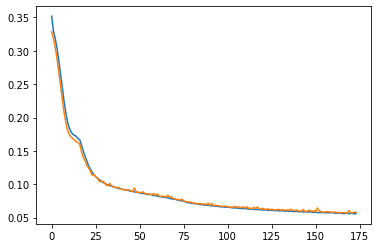

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [16]:
res = model.evaluate(X_test_pad, y_test_pad, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}, or {res[1]/bench_res:.2f} times the benchmark')

MAE on the test set : 0.0532, or 0.34 times the benchmark


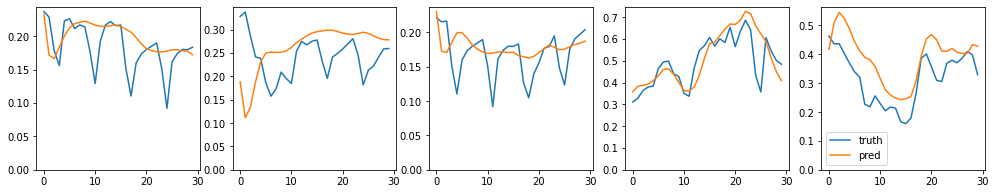

In [17]:
plt.figure(figsize=(17,3))
for id_plot, id_seq in enumerate(np.random.randint(low=0,high=len(X_test),size=5)):
    plt.subplot(1, 5, id_plot+1)
    plt.plot(y_test[id_seq], label='truth')
    plt.plot(model.predict(X_test_pad)[id_seq], label='pred')
    plt.ylim(ymin=0)
plt.legend();